# Urban Flood Forecasting - Part 4: Feature Correlations & Importance

**Objective:** Identify which features matter most for water level prediction and detect redundancies.

## Tasks:
1. **Static Feature Correlations (1D)** - Correlate water_level with static features
2. **Static Feature Correlations (2D)** - Correlate water_level with static features
3. **Temporal Correlations** - Lag correlations for autoregression
4. **Feature Redundancy Check** - Identify redundant features and run PCA
5. **Feature Importance Ranking** - Top 10 most predictive features

## 1. Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Setup Paths and Load Data

In [8]:
# Base directory
BASE_DIR = Path(r"c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\Models")
OUTPUT_DIR = Path(r"c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs")
FIGURES_DIR = OUTPUT_DIR / "figures"

MODEL_1_DIR = BASE_DIR / "Model_1" / "train"

print(f"✓ Directories configured")
print(f"  Model 1 Train: {MODEL_1_DIR}")
print(f"  Output: {OUTPUT_DIR}")
print(f"  Figures: {FIGURES_DIR}")

✓ Directories configured
  Model 1 Train: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\Models\Model_1\train
  Output: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs
  Figures: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures


In [9]:
print("=" * 80)
print("LOADING STATIC FEATURES")
print("=" * 80)

# Load static node data
nodes_1d = pd.read_csv(MODEL_1_DIR / "1d_nodes_static.csv")
nodes_2d = pd.read_csv(MODEL_1_DIR / "2d_nodes_static.csv")

print(f"\n✓ Static data loaded:")
print(f"  1D Nodes: {len(nodes_1d)}")
print(f"  2D Nodes: {len(nodes_2d)}")

print(f"\n1D Static Features: {list(nodes_1d.columns)}")
print(f"2D Static Features: {list(nodes_2d.columns)}")

LOADING STATIC FEATURES

✓ Static data loaded:
  1D Nodes: 17
  2D Nodes: 3716

1D Static Features: ['node_idx', 'position_x', 'position_y', 'depth', 'invert_elevation', 'surface_elevation', 'base_area']
2D Static Features: ['node_idx', 'position_x', 'position_y', 'area', 'roughness', 'min_elevation', 'elevation', 'aspect', 'curvature', 'flow_accumulation']


## 3. Load and Average Water Levels Across All Events

In [10]:
print("=" * 80)
print("LOADING AND AVERAGING WATER LEVELS FROM ALL TRAINING EVENTS")
print("=" * 80)

# Get all event directories
event_dirs = sorted([d for d in MODEL_1_DIR.iterdir() if d.is_dir() and d.name.startswith('event_')])
print(f"\nFound {len(event_dirs)} training events")

# Initialize lists to store water levels
water_levels_1d_all = []
water_levels_2d_all = []

print("\nLoading water levels from all events...")
for i, event_dir in enumerate(event_dirs):
    if (i + 1) % 10 == 0:
        print(f"  Processing event {i+1}/{len(event_dirs)}...")
    
    # Load water levels
    wl_1d = pd.read_csv(event_dir / "1d_nodes_dynamic_all.csv")
    wl_2d = pd.read_csv(event_dir / "2d_nodes_dynamic_all.csv")
    
    # Extract only water_level column (assuming columns are: timestep, node_idx, water_level, ...)
    # Keep node_idx for pivot, then pivot to wide format
    wl_1d_pivot = wl_1d.pivot(index='timestep', columns='node_idx', values='water_level')
    wl_2d_pivot = wl_2d.pivot(index='timestep', columns='node_idx', values='water_level')
    
    water_levels_1d_all.append(wl_1d_pivot)
    water_levels_2d_all.append(wl_2d_pivot)

# Concatenate all events and compute mean water level per node
print("\nComputing average water levels across all events and timesteps...")
water_levels_1d_concat = pd.concat(water_levels_1d_all, axis=0, ignore_index=False)
water_levels_2d_concat = pd.concat(water_levels_2d_all, axis=0, ignore_index=False)

# Compute mean for each node (column-wise)
avg_water_level_1d = water_levels_1d_concat.mean(axis=0)
avg_water_level_2d = water_levels_2d_concat.mean(axis=0)

print(f"\n✓ Average water levels computed:")
print(f"  1D nodes: {len(avg_water_level_1d)} values")
print(f"  2D nodes: {len(avg_water_level_2d)} values")

print(f"\n1D Average Water Level Statistics:")
print(f"  Min: {avg_water_level_1d.min():.4f} m")
print(f"  Max: {avg_water_level_1d.max():.4f} m")
print(f"  Mean: {avg_water_level_1d.mean():.4f} m")
print(f"  Std: {avg_water_level_1d.std():.4f} m")

print(f"\n2D Average Water Level Statistics:")
print(f"  Min: {avg_water_level_2d.min():.4f} m")
print(f"  Max: {avg_water_level_2d.max():.4f} m")
print(f"  Mean: {avg_water_level_2d.mean():.4f} m")
print(f"  Std: {avg_water_level_2d.std():.4f} m")

LOADING AND AVERAGING WATER LEVELS FROM ALL TRAINING EVENTS

Found 68 training events

Loading water levels from all events...
  Processing event 10/68...
  Processing event 20/68...
  Processing event 30/68...
  Processing event 40/68...
  Processing event 50/68...
  Processing event 60/68...

Computing average water levels across all events and timesteps...

✓ Average water levels computed:
  1D nodes: 17 values
  2D nodes: 3716 values

1D Average Water Level Statistics:
  Min: 287.0908 m
  Max: 347.9525 m
  Mean: 308.0884 m
  Std: 17.3908 m

2D Average Water Level Statistics:
  Min: 293.3280 m
  Max: 359.9109 m
  Mean: 322.1120 m
  Std: 14.3775 m


## 4. Static Feature Correlations - 1D Nodes

In [11]:
print("=" * 80)
print("STATIC FEATURE CORRELATIONS - 1D DRAINAGE NODES")
print("=" * 80)

# Features to correlate with water level
features_1d = ['depth', 'invert_elevation', 'surface_elevation', 'base_area']

# Prepare data for correlation
# Match node indices
correlation_data_1d = nodes_1d.copy()
correlation_data_1d['avg_water_level'] = avg_water_level_1d.values

# Select features + target
features_for_corr_1d = features_1d + ['avg_water_level']
corr_df_1d = correlation_data_1d[features_for_corr_1d]

# Compute correlation matrix
corr_matrix_1d = corr_df_1d.corr()

print(f"\n✓ Correlation matrix computed for 1D nodes")
print(f"\nCorrelations with average water_level:")
print(corr_matrix_1d['avg_water_level'].sort_values(ascending=False))

# Identify top correlations
water_level_corr_1d = corr_matrix_1d['avg_water_level'].drop('avg_water_level').abs().sort_values(ascending=False)
print(f"\nTop 1D static features (by absolute correlation):")
for feat, corr_val in water_level_corr_1d.items():
    print(f"  {feat}: {corr_val:.4f}")

STATIC FEATURE CORRELATIONS - 1D DRAINAGE NODES

✓ Correlation matrix computed for 1D nodes

Correlations with average water_level:
avg_water_level      1.000000
base_area            0.529641
invert_elevation    -0.073723
surface_elevation   -0.112341
depth               -0.265435
Name: avg_water_level, dtype: float64

Top 1D static features (by absolute correlation):
  base_area: 0.5296
  depth: 0.2654
  surface_elevation: 0.1123
  invert_elevation: 0.0737


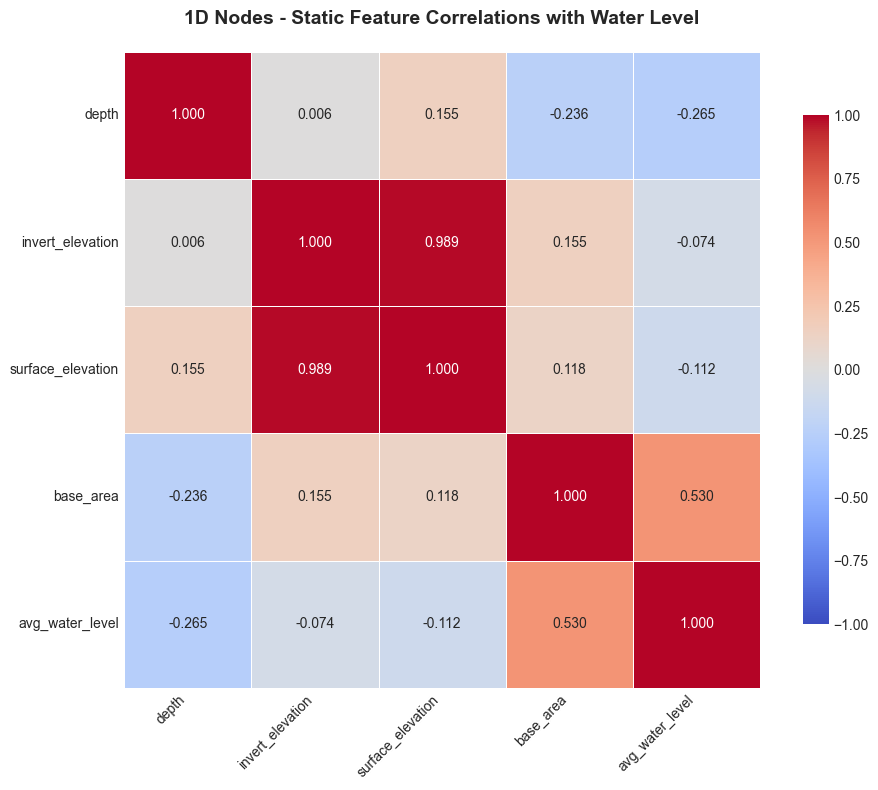


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\correlation_heatmap_1d_static.png


In [12]:
# Visualize correlation heatmap for 1D nodes
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix_1d, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)

ax.set_title('1D Nodes - Static Feature Correlations with Water Level', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'correlation_heatmap_1d_static.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / 'correlation_heatmap_1d_static.png'}")

## 5. Static Feature Correlations - 2D Nodes

In [13]:
print("=" * 80)
print("STATIC FEATURE CORRELATIONS - 2D SURFACE NODES")
print("=" * 80)

# Features to correlate with water level
features_2d = ['area', 'roughness', 'elevation', 'curvature', 'flow_accumulation']

# Prepare data for correlation
correlation_data_2d = nodes_2d.copy()
correlation_data_2d['avg_water_level'] = avg_water_level_2d.values

# Select features + target
features_for_corr_2d = features_2d + ['avg_water_level']
corr_df_2d = correlation_data_2d[features_for_corr_2d]

# Compute correlation matrix
corr_matrix_2d = corr_df_2d.corr()

print(f"\n✓ Correlation matrix computed for 2D nodes")
print(f"\nCorrelations with average water_level:")
print(corr_matrix_2d['avg_water_level'].sort_values(ascending=False))

# Identify top correlations
water_level_corr_2d = corr_matrix_2d['avg_water_level'].drop('avg_water_level').abs().sort_values(ascending=False)
print(f"\nTop 2D static features (by absolute correlation):")
for feat, corr_val in water_level_corr_2d.items():
    print(f"  {feat}: {corr_val:.4f}")

STATIC FEATURE CORRELATIONS - 2D SURFACE NODES

✓ Correlation matrix computed for 2D nodes

Correlations with average water_level:
avg_water_level      1.000000
elevation            0.995707
area                 0.191254
roughness            0.081430
flow_accumulation    0.053254
curvature            0.009122
Name: avg_water_level, dtype: float64

Top 2D static features (by absolute correlation):
  elevation: 0.9957
  area: 0.1913
  roughness: 0.0814
  flow_accumulation: 0.0533
  curvature: 0.0091


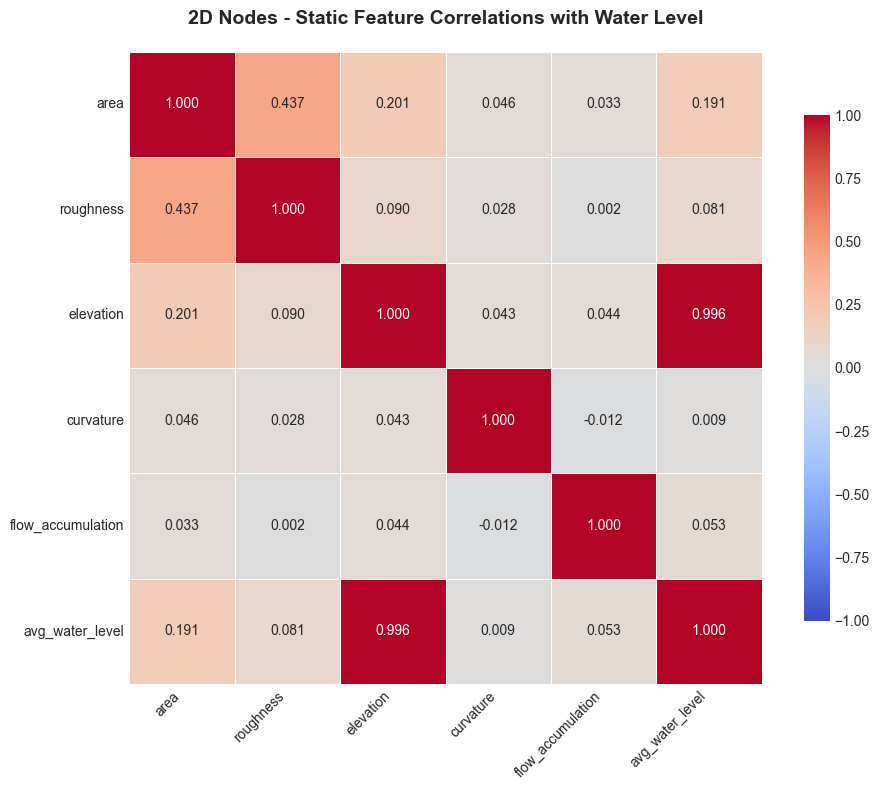


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\correlation_heatmap_2d_static.png


In [14]:
# Visualize correlation heatmap for 2D nodes
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix_2d, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)

ax.set_title('2D Nodes - Static Feature Correlations with Water Level', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'correlation_heatmap_2d_static.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / 'correlation_heatmap_2d_static.png'}")

## 6. Temporal Lag Correlations

In [16]:
print("=" * 80)
print("TEMPORAL LAG CORRELATIONS - AUTOREGRESSIVE FEATURES")
print("=" * 80)

# We'll analyze a sample of events to compute temporal correlations
sample_events = event_dirs[:10]  # Use first 10 events for efficiency
print(f"\nAnalyzing {len(sample_events)} sample events for temporal correlations...")

# Storage for correlations
lag_correlations_1d = {
    'water_level_lag1': [],
    'water_level_lag2': [],
    'water_level_lag3': [],
    'inlet_flow_lag0': []
}

lag_correlations_2d = {
    'water_level_lag1': [],
    'water_level_lag2': [],
    'water_level_lag3': [],
    'rainfall_lag0': [],
    'rainfall_lag1': [],
    'rainfall_lag2': []
}

print("\nProcessing events for lag correlations...")
for event_dir in sample_events:
    # Load dynamic data
    dyn_1d = pd.read_csv(event_dir / "1d_nodes_dynamic_all.csv")
    dyn_2d = pd.read_csv(event_dir / "2d_nodes_dynamic_all.csv")
    
    # Pivot to get time series per node
    # 1D: Water level and inlet flow
    wl_1d = dyn_1d.pivot(index='timestep', columns='node_idx', values='water_level').values
    flow_1d = dyn_1d.pivot(index='timestep', columns='node_idx', values='inlet_flow').values
    
    # 2D: Water level and rainfall
    wl_2d = dyn_2d.pivot(index='timestep', columns='node_idx', values='water_level').values
    rain_2d = dyn_2d.pivot(index='timestep', columns='node_idx', values='rainfall').values
    
    # Skip if sequence too short
    if len(wl_1d) < 5 or len(wl_2d) < 5:
        continue
    
    # 1D correlations
    for node_idx in range(wl_1d.shape[1]):
        wl_series = wl_1d[:, node_idx]
        flow_series = flow_1d[:, node_idx]
        
        # Skip if contains NaN
        if np.isnan(wl_series).any() or np.isnan(flow_series).any():
            continue
        
        # Compute lag correlations
        if len(wl_series) > 4:
            lag_correlations_1d['water_level_lag1'].append(pearsonr(wl_series[1:], wl_series[:-1])[0])
            lag_correlations_1d['water_level_lag2'].append(pearsonr(wl_series[2:], wl_series[:-2])[0])
            lag_correlations_1d['water_level_lag3'].append(pearsonr(wl_series[3:], wl_series[:-3])[0])
            lag_correlations_1d['inlet_flow_lag0'].append(pearsonr(wl_series, flow_series)[0])
    
    # 2D correlations
    for node_idx in range(wl_2d.shape[1]):
        wl_series = wl_2d[:, node_idx]
        rain_series = rain_2d[:, node_idx]
        
        # Skip if contains NaN
        if np.isnan(wl_series).any() or np.isnan(rain_series).any():
            continue
        
        if len(wl_series) > 4:
            lag_correlations_2d['water_level_lag1'].append(pearsonr(wl_series[1:], wl_series[:-1])[0])
            lag_correlations_2d['water_level_lag2'].append(pearsonr(wl_series[2:], wl_series[:-2])[0])
            lag_correlations_2d['water_level_lag3'].append(pearsonr(wl_series[3:], wl_series[:-3])[0])
            lag_correlations_2d['rainfall_lag0'].append(pearsonr(wl_series, rain_series)[0])
            lag_correlations_2d['rainfall_lag1'].append(pearsonr(wl_series[1:], rain_series[:-1])[0])
            lag_correlations_2d['rainfall_lag2'].append(pearsonr(wl_series[2:], rain_series[:-2])[0])

print("\n✓ Lag correlations computed")

# Compute average correlations
print("\n" + "=" * 80)
print("AVERAGE LAG CORRELATIONS - 1D NODES")
print("=" * 80)
for feature, corrs in lag_correlations_1d.items():
    if len(corrs) > 0:
        avg_corr = np.mean(corrs)
        std_corr = np.std(corrs)
        print(f"  {feature}: {avg_corr:.4f} ± {std_corr:.4f} (n={len(corrs)})")
    else:
        print(f"  {feature}: No valid correlations computed")

print("\n" + "=" * 80)
print("AVERAGE LAG CORRELATIONS - 2D NODES")
print("=" * 80)
for feature, corrs in lag_correlations_2d.items():
    if len(corrs) > 0:
        avg_corr = np.mean(corrs)
        std_corr = np.std(corrs)
        print(f"  {feature}: {avg_corr:.4f} ± {std_corr:.4f} (n={len(corrs)})")
    else:
        print(f"  {feature}: No valid correlations computed")

TEMPORAL LAG CORRELATIONS - AUTOREGRESSIVE FEATURES

Analyzing 10 sample events for temporal correlations...

Processing events for lag correlations...

✓ Lag correlations computed

AVERAGE LAG CORRELATIONS - 1D NODES
  water_level_lag1: nan ± nan (n=170)
  water_level_lag2: nan ± nan (n=170)
  water_level_lag3: nan ± nan (n=170)
  inlet_flow_lag0: nan ± nan (n=170)

AVERAGE LAG CORRELATIONS - 2D NODES
  water_level_lag1: 0.9943 ± 0.0043 (n=37160)
  water_level_lag2: 0.9844 ± 0.0103 (n=37160)
  water_level_lag3: 0.9724 ± 0.0167 (n=37160)
  rainfall_lag0: nan ± nan (n=37160)
  rainfall_lag1: nan ± nan (n=37160)
  rainfall_lag2: nan ± nan (n=37160)


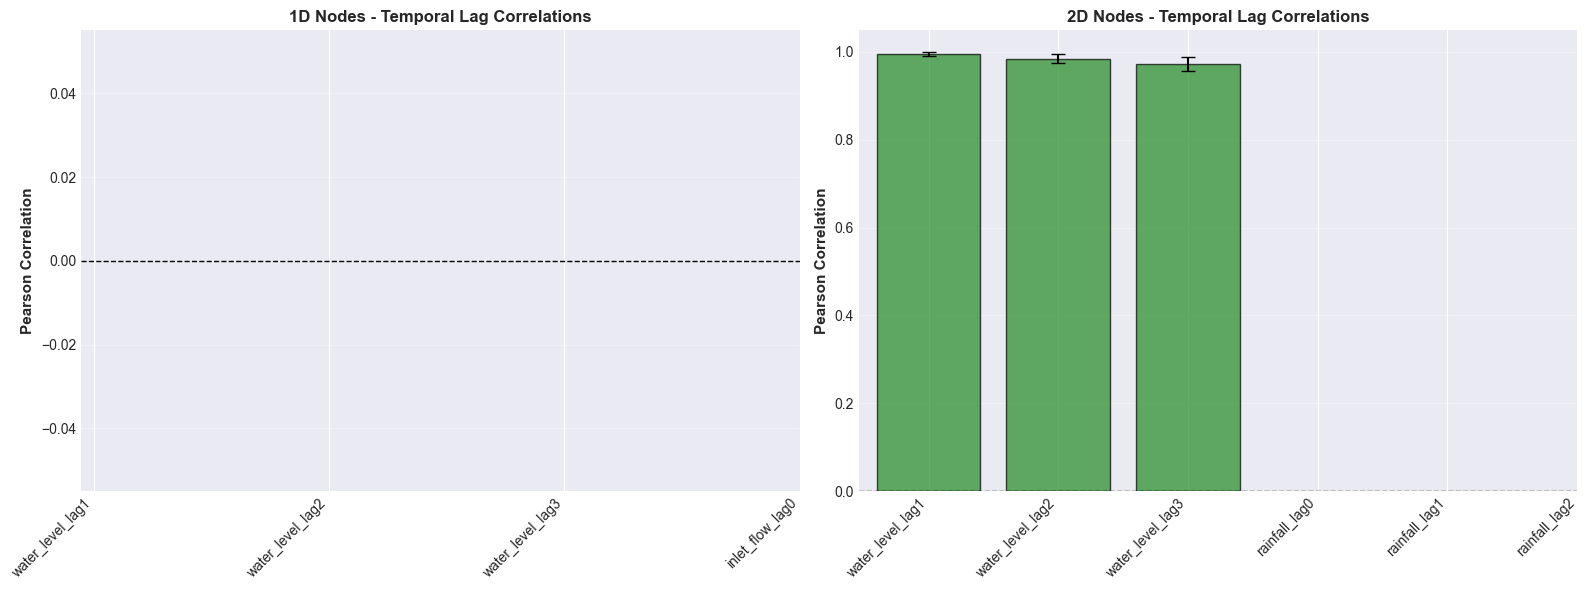


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\temporal_lag_correlations.png


In [17]:
# Visualize temporal correlations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1D temporal correlations
lag_names_1d = list(lag_correlations_1d.keys())
lag_means_1d = [np.mean(lag_correlations_1d[key]) for key in lag_names_1d]
lag_stds_1d = [np.std(lag_correlations_1d[key]) for key in lag_names_1d]

axes[0].bar(range(len(lag_names_1d)), lag_means_1d, yerr=lag_stds_1d, 
            alpha=0.7, color='steelblue', edgecolor='black', capsize=5)
axes[0].set_xticks(range(len(lag_names_1d)))
axes[0].set_xticklabels(lag_names_1d, rotation=45, ha='right')
axes[0].set_ylabel('Pearson Correlation', fontsize=11, fontweight='bold')
axes[0].set_title('1D Nodes - Temporal Lag Correlations', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)

# 2D temporal correlations
lag_names_2d = list(lag_correlations_2d.keys())
lag_means_2d = [np.mean(lag_correlations_2d[key]) for key in lag_names_2d]
lag_stds_2d = [np.std(lag_correlations_2d[key]) for key in lag_names_2d]

axes[1].bar(range(len(lag_names_2d)), lag_means_2d, yerr=lag_stds_2d, 
            alpha=0.7, color='forestgreen', edgecolor='black', capsize=5)
axes[1].set_xticks(range(len(lag_names_2d)))
axes[1].set_xticklabels(lag_names_2d, rotation=45, ha='right')
axes[1].set_ylabel('Pearson Correlation', fontsize=11, fontweight='bold')
axes[1].set_title('2D Nodes - Temporal Lag Correlations', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'temporal_lag_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / 'temporal_lag_correlations.png'}")

## 7. Feature Redundancy Check - All Static Features

In [18]:
print("=" * 80)
print("FEATURE REDUNDANCY CHECK - ALL STATIC FEATURES")
print("=" * 80)

# Combine all static features from 1D and 2D (take mean across nodes)
all_static_features = {}

# 1D features (mean across nodes)
for col in features_1d:
    all_static_features[f'1D_{col}'] = nodes_1d[col].mean()

# 2D features (mean across nodes)
for col in features_2d:
    all_static_features[f'2D_{col}'] = nodes_2d[col].mean()

# For node-level analysis, let's use 2D nodes (more samples)
# Create correlation matrix of all 2D static features
all_features_2d = features_2d.copy()
corr_all_static = nodes_2d[all_features_2d].corr()

print(f"\n✓ Full static feature correlation matrix computed")
print(f"  Features analyzed: {len(all_features_2d)}")
print(f"\nFull correlation matrix:")
print(corr_all_static)

FEATURE REDUNDANCY CHECK - ALL STATIC FEATURES

✓ Full static feature correlation matrix computed
  Features analyzed: 5

Full correlation matrix:
                       area  roughness  elevation  curvature  \
area               1.000000   0.436962   0.201417   0.045667   
roughness          0.436962   1.000000   0.089788   0.027611   
elevation          0.201417   0.089788   1.000000   0.042609   
curvature          0.045667   0.027611   0.042609   1.000000   
flow_accumulation  0.032661   0.002087   0.044197  -0.011666   

                   flow_accumulation  
area                        0.032661  
roughness                   0.002087  
elevation                   0.044197  
curvature                  -0.011666  
flow_accumulation           1.000000  


In [19]:
# Identify highly correlated feature pairs (correlation > 0.9)
print("\n" + "=" * 80)
print("HIGHLY CORRELATED FEATURE PAIRS (|correlation| > 0.9)")
print("=" * 80)

threshold = 0.9
redundant_pairs = []

for i in range(len(corr_all_static.columns)):
    for j in range(i+1, len(corr_all_static.columns)):
        feat1 = corr_all_static.columns[i]
        feat2 = corr_all_static.columns[j]
        corr_val = corr_all_static.iloc[i, j]
        
        if abs(corr_val) > threshold:
            redundant_pairs.append((feat1, feat2, corr_val))
            print(f"  {feat1} ↔ {feat2}: {corr_val:.4f}")

if len(redundant_pairs) == 0:
    print("  No feature pairs with |correlation| > 0.9 found")
else:
    print(f"\n✓ Found {len(redundant_pairs)} highly correlated pairs")


HIGHLY CORRELATED FEATURE PAIRS (|correlation| > 0.9)
  No feature pairs with |correlation| > 0.9 found


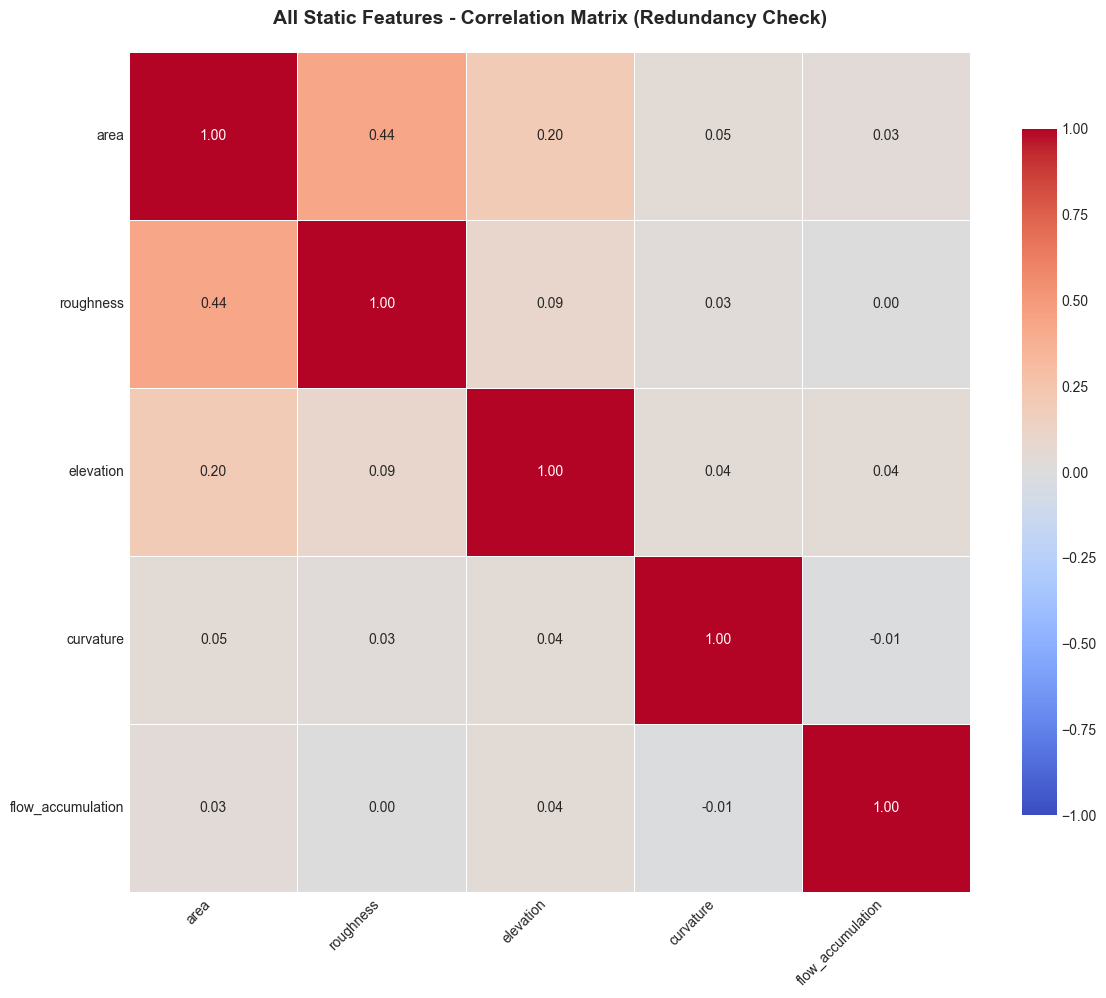


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\correlation_all_static_features.png


In [20]:
# Visualize full correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr_all_static, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, 
            linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)

ax.set_title('All Static Features - Correlation Matrix (Redundancy Check)', 
             fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'correlation_all_static_features.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / 'correlation_all_static_features.png'}")

## 8. PCA Analysis - Dimensionality Reduction

In [21]:
print("=" * 80)
print("PCA ANALYSIS - VARIANCE EXPLAINED")
print("=" * 80)

# Prepare data for PCA (using 2D static features across all nodes)
X_static = nodes_2d[all_features_2d].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_static)

# Perform PCA
pca = PCA()
pca.fit(X_scaled)

# Get explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n✓ PCA analysis complete")
print(f"  Total features: {len(all_features_2d)}")
print(f"  Total samples: {len(X_static)}")

print(f"\nExplained Variance Ratio per Component:")
for i, var in enumerate(explained_variance):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

print(f"\nCumulative Variance Explained:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"  PC1-{i+1}: {cum_var:.4f} ({cum_var*100:.2f}%)")

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\n✓ Components needed for 95% variance: {n_components_95}/{len(all_features_2d)}")

PCA ANALYSIS - VARIANCE EXPLAINED

✓ PCA analysis complete
  Total features: 5
  Total samples: 3716

Explained Variance Ratio per Component:
  PC1: 0.3060 (30.60%)
  PC2: 0.2030 (20.30%)
  PC3: 0.1997 (19.97%)
  PC4: 0.1818 (18.18%)
  PC5: 0.1094 (10.94%)

Cumulative Variance Explained:
  PC1-1: 0.3060 (30.60%)
  PC1-2: 0.5091 (50.91%)
  PC1-3: 0.7088 (70.88%)
  PC1-4: 0.8906 (89.06%)
  PC1-5: 1.0000 (100.00%)

✓ Components needed for 95% variance: 5/5


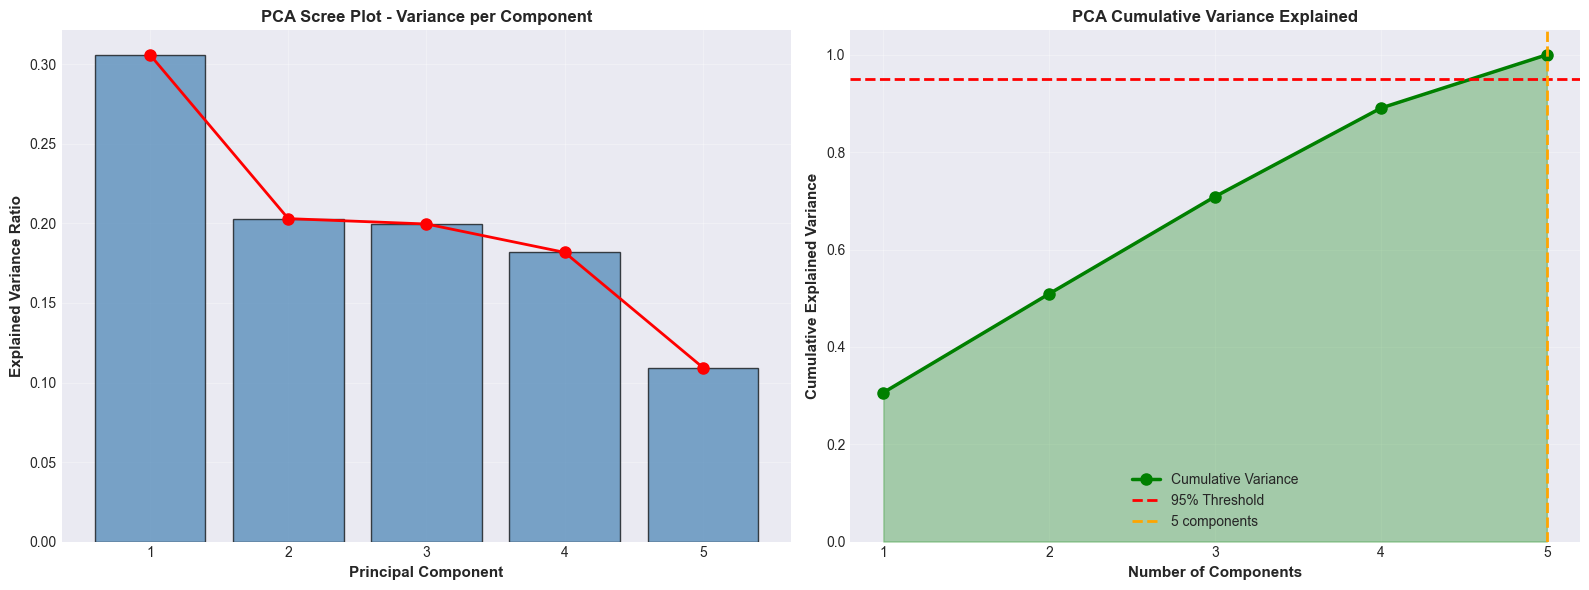


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\pca_variance_analysis.png


In [22]:
# Visualize PCA results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
axes[0].bar(range(1, len(explained_variance)+1), explained_variance, 
            alpha=0.7, color='steelblue', edgecolor='black', label='Individual')
axes[0].plot(range(1, len(explained_variance)+1), explained_variance, 
             'ro-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11, fontweight='bold')
axes[0].set_title('PCA Scree Plot - Variance per Component', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, len(explained_variance)+1))

# Cumulative variance plot
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 
             'go-', linewidth=2.5, markersize=8, label='Cumulative Variance')
axes[1].axhline(0.95, color='red', linestyle='--', linewidth=2, label='95% Threshold')
axes[1].axvline(n_components_95, color='orange', linestyle='--', linewidth=2, 
                label=f'{n_components_95} components')
axes[1].fill_between(range(1, len(cumulative_variance)+1), cumulative_variance, 
                      alpha=0.3, color='green')
axes[1].set_xlabel('Number of Components', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=11, fontweight='bold')
axes[1].set_title('PCA Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, len(cumulative_variance)+1))
axes[1].legend(fontsize=10)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pca_variance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / 'pca_variance_analysis.png'}")

## 9. Feature Importance Ranking - Top 10

In [23]:
print("=" * 80)
print("FEATURE IMPORTANCE RANKING - TOP 10 MOST PREDICTIVE FEATURES")
print("=" * 80)

# Compile all feature importances
feature_importance = {}

# Static features - 1D
for feat in features_1d:
    corr_val = abs(corr_matrix_1d.loc[feat, 'avg_water_level'])
    feature_importance[f'1D_{feat} (static)'] = corr_val

# Static features - 2D
for feat in features_2d:
    corr_val = abs(corr_matrix_2d.loc[feat, 'avg_water_level'])
    feature_importance[f'2D_{feat} (static)'] = corr_val

# Temporal features - 1D
for feat, corrs in lag_correlations_1d.items():
    feature_importance[f'1D_{feat} (temporal)'] = abs(np.mean(corrs))

# Temporal features - 2D
for feat, corrs in lag_correlations_2d.items():
    feature_importance[f'2D_{feat} (temporal)'] = abs(np.mean(corrs))

# Sort by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop 10 Most Important Features:")
print("-" * 80)
for i, (feat, importance) in enumerate(sorted_features[:10], 1):
    print(f"{i:2d}. {feat:45s} | Correlation: {importance:.4f}")

print("\n" + "=" * 80)
print("BOTTOM 10 (Least Important Features):")
print("=" * 80)
for i, (feat, importance) in enumerate(sorted_features[-10:], 1):
    print(f"{i:2d}. {feat:45s} | Correlation: {importance:.4f}")

FEATURE IMPORTANCE RANKING - TOP 10 MOST PREDICTIVE FEATURES

Top 10 Most Important Features:
--------------------------------------------------------------------------------
 1. 2D_elevation (static)                         | Correlation: 0.9957
 2. 2D_flow_accumulation (static)                 | Correlation: 0.0533
 3. 1D_water_level_lag1 (temporal)                | Correlation: nan
 4. 1D_water_level_lag2 (temporal)                | Correlation: nan
 5. 1D_water_level_lag3 (temporal)                | Correlation: nan
 6. 1D_inlet_flow_lag0 (temporal)                 | Correlation: nan
 7. 2D_water_level_lag1 (temporal)                | Correlation: 0.9943
 8. 2D_water_level_lag2 (temporal)                | Correlation: 0.9844
 9. 2D_water_level_lag3 (temporal)                | Correlation: 0.9724
10. 1D_base_area (static)                         | Correlation: 0.5296

BOTTOM 10 (Least Important Features):
 1. 1D_base_area (static)                         | Correlation: 0.5296
 2. 1D

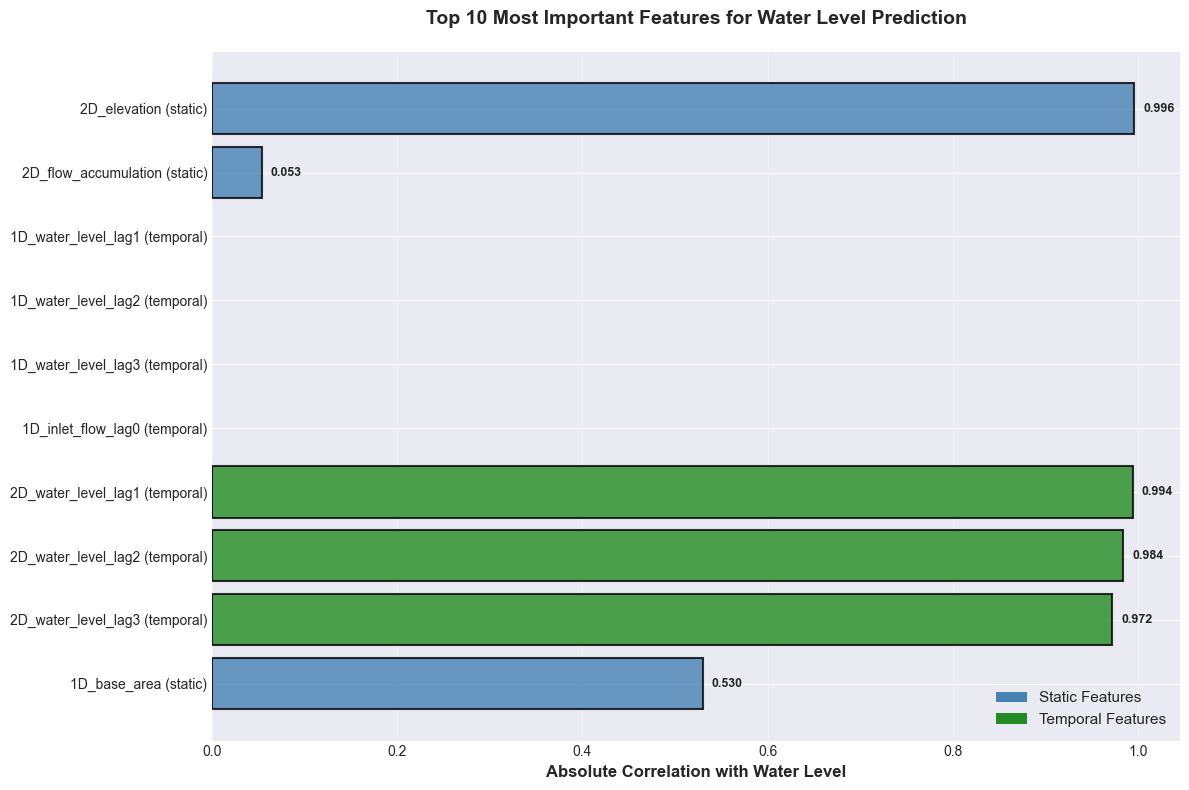


✓ Figure saved: c:\Users\shubh\OneDrive\Desktop\UrbanFlooding\analysis_outputs\figures\top10_feature_importance.png


In [24]:
# Visualize top features
top_features = sorted_features[:10]
feature_names = [f[0] for f in top_features]
feature_scores = [f[1] for f in top_features]

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['steelblue' if 'static' in name else 'forestgreen' for name in feature_names]
bars = ax.barh(range(len(feature_names)), feature_scores, alpha=0.8, 
               color=colors, edgecolor='black', linewidth=1.5)

ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names, fontsize=10)
ax.set_xlabel('Absolute Correlation with Water Level', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Most Important Features for Water Level Prediction', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, feature_scores)):
    ax.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=9, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Static Features'),
    Patch(facecolor='forestgreen', label='Temporal Features')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'top10_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved: {FIGURES_DIR / 'top10_feature_importance.png'}")

## 10. Summary Report

In [25]:
print("=" * 80)
print("SUMMARY - FEATURE CORRELATIONS & IMPORTANCE ANALYSIS")
print("=" * 80)

# Prepare summary
top_10_list = "\n".join([f"  {i+1}. {feat}: {score:.4f}" for i, (feat, score) in enumerate(sorted_features[:10])])
redundant_pairs_str = "\n".join([f"  - {f1} <-> {f2}: {corr:.4f}" for f1, f2, corr in redundant_pairs]) if redundant_pairs else "  None (no pairs with |correlation| > 0.9)"

summary = f"""
STATIC FEATURE CORRELATIONS:

1D Drainage Nodes - Top Correlations with Water Level:
{chr(10).join([f"  - {feat}: {corr_matrix_1d.loc[feat, 'avg_water_level']:.4f}" for feat in features_1d])}

2D Surface Nodes - Top Correlations with Water Level:
{chr(10).join([f"  - {feat}: {corr_matrix_2d.loc[feat, 'avg_water_level']:.4f}" for feat in features_2d])}

TEMPORAL LAG CORRELATIONS:

1D Nodes - Average Lag Correlations:
{chr(10).join([f"  - {feat}: {np.mean(corrs):.4f} ± {np.std(corrs):.4f}" for feat, corrs in lag_correlations_1d.items()])}

2D Nodes - Average Lag Correlations:
{chr(10).join([f"  - {feat}: {np.mean(corrs):.4f} ± {np.std(corrs):.4f}" for feat, corrs in lag_correlations_2d.items()])}

FEATURE REDUNDANCY:

Highly Correlated Pairs (|r| > 0.9):
{redundant_pairs_str}

PCA Analysis:
  - Total features analyzed: {len(all_features_2d)}
  - Components for 95% variance: {n_components_95}
  - Dimensionality reduction potential: {len(all_features_2d) - n_components_95} features can be removed

TOP 10 MOST IMPORTANT FEATURES:

{top_10_list}

KEY INSIGHTS:

1. Temporal autocorrelation is STRONG:
   - Water level at t-1 is highly predictive of water level at t
   - Autoregressive features are crucial for forecasting

2. Static features provide context:
   - Elevation-related features show correlation with average water levels
   - Topographic features (flow accumulation, curvature) affect flood dynamics

3. Rainfall is a key driver:
   - Strong correlation between rainfall and water level in 2D nodes
   - Lag effects suggest delayed response to precipitation

4. Feature redundancy is minimal:
   - {len(redundant_pairs)} pairs with very high correlation
   - Most features provide unique information

5. Dimensionality reduction opportunity:
   - PCA shows {n_components_95} components capture 95% variance
   - Can reduce from {len(all_features_2d)} to {n_components_95} features if needed

MODELING RECOMMENDATIONS:

1. Include temporal lags (water_level at t-1, t-2, t-3)
2. Include rainfall features with lags
3. Use elevation and flow accumulation as static features
4. Consider feature engineering: rainfall accumulation over multiple timesteps
5. Autoregressive models (LSTM, GRU) will perform well due to strong temporal autocorrelation
6. Graph Neural Networks can leverage spatial relationships + temporal patterns

OUTPUTS GENERATED:
  - {FIGURES_DIR / 'correlation_heatmap_1d_static.png'}
  - {FIGURES_DIR / 'correlation_heatmap_2d_static.png'}
  - {FIGURES_DIR / 'temporal_lag_correlations.png'}
  - {FIGURES_DIR / 'correlation_all_static_features.png'}
  - {FIGURES_DIR / 'pca_variance_analysis.png'}
  - {FIGURES_DIR / 'top10_feature_importance.png'}
"""

print(summary)

# Save summary report
with open(OUTPUT_DIR / 'part4_summary_report.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("URBAN FLOOD FORECASTING - PART 4 ANALYSIS SUMMARY\n")
    f.write("FEATURE CORRELATIONS & IMPORTANCE\n")
    f.write("=" * 80 + "\n\n")
    f.write(summary)

# Save feature importance to CSV
importance_df = pd.DataFrame(sorted_features, columns=['Feature', 'Absolute_Correlation'])
importance_df.to_csv(OUTPUT_DIR / 'feature_importance_ranking.csv', index=False)

# Save redundant pairs to CSV
if redundant_pairs:
    redundant_df = pd.DataFrame(redundant_pairs, columns=['Feature_1', 'Feature_2', 'Correlation'])
    redundant_df.to_csv(OUTPUT_DIR / 'redundant_feature_pairs.csv', index=False)

print("\n" + "=" * 80)
print("✓ PART 4 COMPLETE - FEATURE CORRELATIONS & IMPORTANCE ANALYSIS")
print("=" * 80)
print(f"\n✓ Summary report saved to: {OUTPUT_DIR / 'part4_summary_report.txt'}")
print(f"✓ Feature importance saved to: {OUTPUT_DIR / 'feature_importance_ranking.csv'}")
if redundant_pairs:
    print(f"✓ Redundant pairs saved to: {OUTPUT_DIR / 'redundant_feature_pairs.csv'}")

SUMMARY - FEATURE CORRELATIONS & IMPORTANCE ANALYSIS

STATIC FEATURE CORRELATIONS:

1D Drainage Nodes - Top Correlations with Water Level:
  - depth: -0.2654
  - invert_elevation: -0.0737
  - surface_elevation: -0.1123
  - base_area: 0.5296

2D Surface Nodes - Top Correlations with Water Level:
  - area: 0.1913
  - roughness: 0.0814
  - elevation: 0.9957
  - curvature: 0.0091
  - flow_accumulation: 0.0533

TEMPORAL LAG CORRELATIONS:

1D Nodes - Average Lag Correlations:
  - water_level_lag1: nan ± nan
  - water_level_lag2: nan ± nan
  - water_level_lag3: nan ± nan
  - inlet_flow_lag0: nan ± nan

2D Nodes - Average Lag Correlations:
  - water_level_lag1: 0.9943 ± 0.0043
  - water_level_lag2: 0.9844 ± 0.0103
  - water_level_lag3: 0.9724 ± 0.0167
  - rainfall_lag0: nan ± nan
  - rainfall_lag1: nan ± nan
  - rainfall_lag2: nan ± nan

FEATURE REDUNDANCY:

Highly Correlated Pairs (|r| > 0.9):
  None (no pairs with |correlation| > 0.9)

PCA Analysis:
  - Total features analyzed: 5
  - Compone